# Variational Autoencoder

In [1]:
#mathematics
using LinearAlgebra
using ForwardDiff

#datasets
using MLDatasets

#statistics
using Distributions
using Statistics
using Random
using StatsBase

#visualize
using Plots
pyplot()

#macros
using ProgressMeter
using UnPack

#threads
using Base.Threads
nthreads()

1

## 1. Prepare data

In [2]:
#reshape images
function vecX(x)
    d1,d2,N = size(x)
    X = zeros(d1*d2, N)
    for n in 1:N
        X[:,n] = x[:,:,n][:]
    end
    return X
end

#get the train data
train_x, train_y = MNIST.traindata()
X = vecX(train_x)

#images whose labels are 0 or 1
idx0or1 = Bool.((train_y.==0) + (train_y.==1))
X = X[:,idx0or1]
Y = train_y[idx0or1]

#data
Dx, N = size(X)
data = (X=X, Dx=Dx, N=N)

(X = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Dx = 784, N = 12665)

In [3]:
#initialize the parameter
function init_params(st)
    @unpack  DI, DO, DM = st
    W₂ = randn(DM, DI)
    W₃ = randn(DO, DM)
    b₂ = zeros(DM)
    b₃ = zeros(DO)
    return W₂, W₃, b₂, b₃
end

#stick the weights and biases to a large matrix
function stick_params(W₂, W₃, b₂, b₃, Dx)
    tmp1 = vcat(b₂', W₂')
    tmp2 = hcat(tmp1, zeros(Dx+1))
    tmp3 = hcat(W₃, b₃)
    return vcat(tmp2, tmp3)
end

#devide the paramters vector to weights and biases
function reshape_params(wvec, st)
    @unpack  DI, DO, DM = st
    W = reshape(wvec, (DI+DO+1, DM+1))
    W₂ = view(W, 2:DI+1, 1:DM)'
    W₃ = view(W, DI+2:DI+DO+1, 1:DM)
    b₂ = view(W, 1, 1:DM)
    b₃ = view(W, DI+2:DI+DO+1, DM+1)
    return W₂, W₃, b₂, b₃
end 

#Neural Network
function nn(x, wvec, st)
   @unpack  DI, DO, DM = st
    W₂, W₃, b₂, b₃ = reshape_params(wvec, st)
    return W₃*tanh.(W₂*x+b₂) + b₃
end

nn (generic function with 1 method)

In [26]:
#encoder and decoder
Φ(zn, wvec, stΦ) = nn(zn, wvec, stΦ)
Ψ(xn, ηvec, stΨ) = nn(xn, ηvec, stΨ)

#mean and logstd, std
function mean_and_logstd(vecn, pvec, D, st)
    tmp = nn(vecn, pvec, st)
    @inbounds tmp[1:D], tmp[D+1:end]
end

function mean_and_std(vecn, pvec, D, st)
    mvec, logsvec = mean_and_logstd(vecn, pvec, D, st)
    mvec, exp.(logsvec)
end

#used for reparameterization trick of zn
g(ϵvec, θvec, dw) = θvec[1:dw] + exp.(θvec[dw+1:end]) .* ϵvec
function h(ϵvec, ηvec, xn, Dz, stΨ)
    mvec, svec = mean_and_std(xn, ηvec, Dz, stΨ)
    mvec + svec .* ϵvec
end

#logpmodel
function logpmodel(xn, zn, wvec, Dx, stΦ)
    mvec, svec = mean_and_std(zn, wvec, Dx, stΦ)
    logpdf(MvNormal(mvec, svec), xn)
end
logpmodel(xn,ηvec,θvec,ϵzvec,ϵwvec,Dx,Dz,dw,stΦ,stΨ) = (
    logpmodel(xn,h(ϵzvec,ηvec,xn,Dz,stΨ),g(ϵwvec, θvec, dw),Dx,stΦ)
)

#used for calculation of ELBO
function fn(xn, ηvec, Dz, stΨ)
    mvec, logsvec = mean_and_logstd(xn, ηvec, Dz, stΨ)
    Dz/2 + sum(logsvec) - norm(mvec)^2/2 - norm(exp.(logsvec))^2/2
end
f(θvec,λw,dw)=dw/2*(1+log(λw))-λw*(norm(θvec[1:dw])^2+norm(exp.(θvec[dw+1:end]))^2)/2+sum(θvec[dw+1:end])

#ELBO
function ELBO(X, ηvec, θvec, ϵzsamps, ϵwsamps, λw, N, Dx, Dz, S, stΦ, stΨ)
    logpmodels = zeros(S)
    sumvec = zeros(N)
    for n in 1:N
        for s in 1:S
            @inbounds logpmodels[s] = logpmodel(X[:,n],ηvec,θvec,ϵzsamps[:,s],ϵwsamps[:,s],Dx,Dz,dw,stΦ,stΨ)
        end
        @inbounds sumvec[n] = mean(logpmodels) + fn(X[:,n], ηvec, Dz, stΨ)
    end
    sum(sumvec) + f(θvec,λw,dw)
end

#approximatio of ELBO Ln
ELBOn(xn,ηvec,θvec,ϵzvec,ϵwvec,Dx,Dz,dw,stΦ,stΨ) = (
    logpmodel(xn,ηvec,θvec,ϵzvec,ϵwvec,Dx,Dz,dw,stΦ,stΨ) + fn(xn,ηvec,Dz,stΨ)
)

#gradient of ELBO w.r.t θ and η
∇θLn_samp(xm,ηvec,θvec,ϵzsamp,ϵwsamp,Dx,Dz,dw,stΦ,stΨ) = (
    ForwardDiff.gradient(vec->ELBOn(xm,ηvec,vec,ϵzsamp,ϵwsamp,Dx,Dz,dw,stΦ,stΨ), θvec)
)
∇θf(θvec, λw, dw) = ForwardDiff.gradient(vec->f(vec, λw, dw), θvec)
function ∇θLn(minibatch, minibatch_size, N, ηvec, θvec, ϵzsamp, ϵwsamp, λw, Dx, Dz, dw, stΦ, stΨ)
    ∇θLnvec = zeros(2*dw, minibatch_size)
    @threads for m in 1:minibatch_size
        @inbounds ∇θLnvec[:,m] = ∇θLn_samp(minibatch[:,m],ηvec,θvec,ϵzsamp,ϵwsamp,Dx,Dz,dw,stΦ,stΨ)
    end
    N*mean(∇θLnvec, dims=2) + ∇θf(θvec, λw, dw)
end

∇ηLn_samp(xm,ηvec,θvec,ϵzsamp,ϵwsamp,Dx,Dz,dw,stΦ,stΨ) = (
    ForwardDiff.gradient(vec->ELBOn(xm,vec,θvec,ϵzsamp,ϵwsamp,Dx,Dz,dw,stΦ,stΨ), ηvec)
)
function ∇ηLn(minibatch, minibatch_size, N, ηvec, θvec, ϵzsamp, ϵwsamp, Dx, Dz, dw, stΦ, stΨ)
    ∇ηLnvec = zeros(dη, minibatch_size)
    @threads for m in 1:minibatch_size
        @inbounds ∇ηLnvec[:,m] =  ∇ηLn_samp(minibatch[:,m],ηvec,θvec,ϵzsamp,ϵwsamp,Dx,Dz,dw,stΦ,stΨ)
    end
    N*mean(∇ηLnvec, dims=2)
end   

#variational infernce
function myVI(data, model_params, n_train, minibatch_size, α)
    #initalize and set the parameters
    @unpack X,Dx,N = data
    @unpack λw,dw,dη,Dz,stΦ,stΨ,ηvec₀ = model_params
    θvec = vcat(zeros(dw), ones(dw))
    ηvec = ηvec₀
    
    #minibatch
    minibatch = zeros(Dx,minibatch_size)
    
    #ELBO interval
    Δ = 10
    
    #AdaGrad
    δ = 1e-7
    gθvec = zeros(2*dw)
    gηvec = zeros(dη)
    rθvec = δ * ones(2*dw)
    rηvec = δ * ones(dη)
    
    #ELBO
    S = 100
    ϵzsamp = rand(MvNormal(zeros(Dz), ones(Dz)))
    ϵwsamp = rand(MvNormal(zeros(dw), ones(dw)))
    ϵzsamps = rand(MvNormal(zeros(Dz), ones(Dz)), S)
    ϵwsamps = rand(MvNormal(zeros(dw), ones(dw)), S)
    history = zeros(div(n_train, Δ))
    @inbounds @showprogress for k in 2:n_train
        #choose mini batch
        minibatch = X[:,sample(1:N, minibatch_size, replace=false)]
        
        #update(AdaGrad)
        ϵzsamp = rand(MvNormal(zeros(Dz), ones(Dz)))
        ϵwsamp = rand(MvNormal(zeros(dw), ones(dw)))
        gθvec = ∇θLn(minibatch, minibatch_size, N, ηvec, θvec, ϵzsamp, ϵwsamp, λw, Dx, Dz, dw, stΦ, stΨ)
        gηvec = ∇ηLn(minibatch, minibatch_size, N, ηvec, θvec, ϵzsamp, ϵwsamp, Dx, Dz, dw, stΦ, stΨ)
        rθvec = rθvec + gθvec .* gθvec
        rηvec = rηvec + gηvec .* gηvec
        θvec += α * gθvec ./ sqrt.(rθvec)
        ηvec += α * gηvec ./ sqrt.(rηvec)
        
        #calculate ELBO
        if k%Δ == 0
            ϵzsamps = rand(MvNormal(zeros(Dz), ones(Dz)), S)
            ϵwsamps = rand(MvNormal(zeros(dw), ones(dw)), S)
            history[div(k,Δ)] = ELBO(X, ηvec, θvec, ϵzsamps, ϵwsamps, λw, N, Dx, Dz, S, stΦ, stΨ)
        end
    end
    return θvec, ηvec, history
end

myVI (generic function with 1 method)

In [29]:
#set the random seed
Random.seed!(42)

#latent dimension
Dz = 2

#initialize Neural Network (decoder)
DΦ = 5
stΦ = (DI=Dz, DO=2*Dx, DM=DΦ)
WΦ₂, WΦ₃, bΦ₂, bΦ₃ = init_params(stΦ)
WΦs = stick_params(WΦ₂, WΦ₃, bΦ₂, bΦ₃, stΦ.DI)
wvec₀ = WΦs[:]
dw = length(wvec₀)

#initialize Neural Network (encoder)
DΨ = 5
stΨ = (DI=Dx, DO=2*Dz, DM=DΨ)
WΨ₂, WΨ₃, bΨ₂, bΨ₃ = init_params(stΨ)
WΨs = stick_params(WΨ₂, WΨ₃, bΨ₂, bΨ₃, stΨ.DI)
ηvec₀ = WΨs[:]
dη = length(ηvec₀)

#model parameters
λw = 1
model_params = (λw=λw, dw=dw, dη=dη, Dz=Dz, stΦ=stΦ, stΨ=stΨ, ηvec₀=ηvec₀)

#variational inference
n_train = 2
α = 0.1
minibatch_size = 1
@time θvec, ηvec, history = myVI(data, model_params, n_train, minibatch_size, α)

  7.448080 seconds (113.05 k allocations: 13.106 GiB, 15.40% gc time)


([0.0; 0.0; … ; 1.1; 1.1], [-0.09999999966450178; -0.6011866584471528; … ; -0.1; -0.1], Float64[])

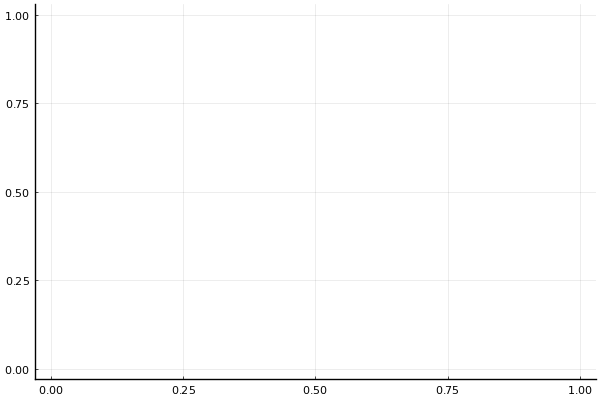

In [30]:
fig1 = plot(history, label=false, marker=:circle)

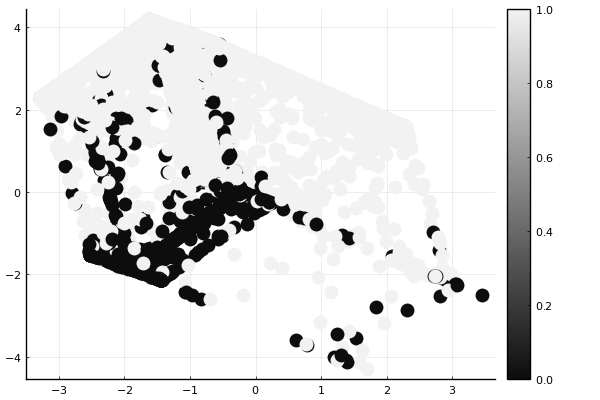

In [32]:
Zs = zeros(Dz, N)
for n in 1:N
    Zs[:,n] = Ψ(X[:,n], ηvec, stΨ)[1:Dz]
end
fig2 = plot(Zs[1,:], Zs[2,:], st=:scatter, zcolor=Y, markersize=10, markerstrokewidth=0, c=palette(:grays), label=false)